In [1]:
import pandas as pd
import shap
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

c:\Users\suchi\Mini\envs\dsi_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# 1. Load data
df = pd.read_csv("data/Transformed_data.csv")
df = df[df['Min Delay'] > 0].copy()
df=df[df['Line'].isin(['YU','BD','SRT'])]
#df.info()
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Hour'] = df['Time'].apply(lambda x: int(x.split(':')[0]))
df['Minute'] = df['Time'].apply(lambda x: int(x.split(':')[1]))
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Delay'] = df['Min Delay']  # Placeholder for delay column
# 2. Define features and target
features = ['Month', 'Hour', 'Minute', 'DayOfWeek', 'Line', 'Station']
target = 'Delay'
X = df[features]
y = df[target]
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 25613 entries, 9 to 69065
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              25613 non-null  datetime64[ns]
 1   Time              25613 non-null  object        
 2   Day               25613 non-null  object        
 3   Station           25613 non-null  object        
 4   Code              25613 non-null  object        
 5   Code Description  25613 non-null  object        
 6   Min Delay         25613 non-null  int64         
 7   Min Gap           25613 non-null  int64         
 8   Line              25613 non-null  object        
 9   Station_Cleaned   25613 non-null  object        
 10  Month             25613 non-null  int32         
 11  Hour              25613 non-null  int64         
 12  Minute            25613 non-null  int64         
 13  DayOfWeek         25613 non-null  int32         
 14  Delay             25613 non

,Date,Time,Day,Station,Code,Code Description,Min Delay,Min Gap,Line,Station_Cleaned,Month,Hour,Minute,DayOfWeek,Delay
9,2022-01-01,7:43,Saturday,WILSON STATION,TUATC,ATC Operator Related,10,0,YU,WILSON STATION,1,7,43,5,10
16,2022-01-01,8:12,Saturday,FINCH STATION,TUNOA,No Operator Immediately Available,6,12,YU,FINCH STATION,1,8,12,5,6
17,2022-01-01,8:28,Saturday,GREENWOOD STATION,TUO,Transportation Department - Other,5,10,BD,GREENWOOD STATION,1,8,28,5,5
24,2022-01-01,9:45,Saturday,KENNEDY BD STATION,TUO,Transportation Department - Other,5,10,BD,KENNEDY STATION,1,9,45,5,5
25,2022-01-01,9:51,Saturday,FINCH STATION,TUNOA,No Operator Immediately Available,6,12,YU,FINCH STATION,1,9,51,5,6


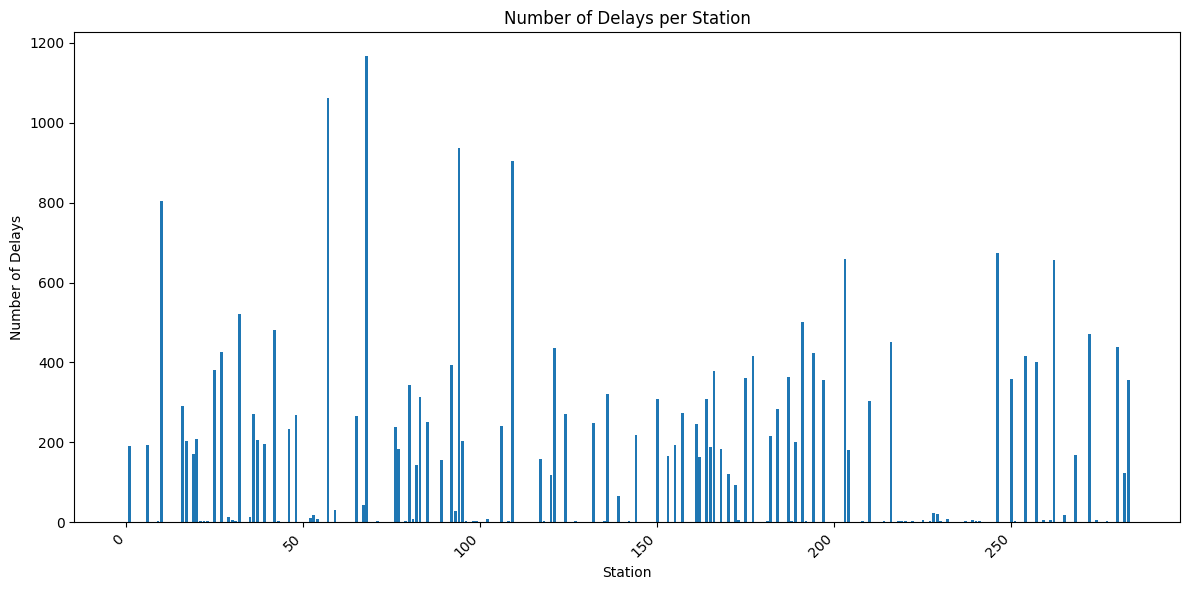

Day
Friday       4015
Tuesday      4010
Wednesday    3906
Thursday     3876
Monday       3865
Saturday     3147
Sunday       2794
Name: count, dtype: int64


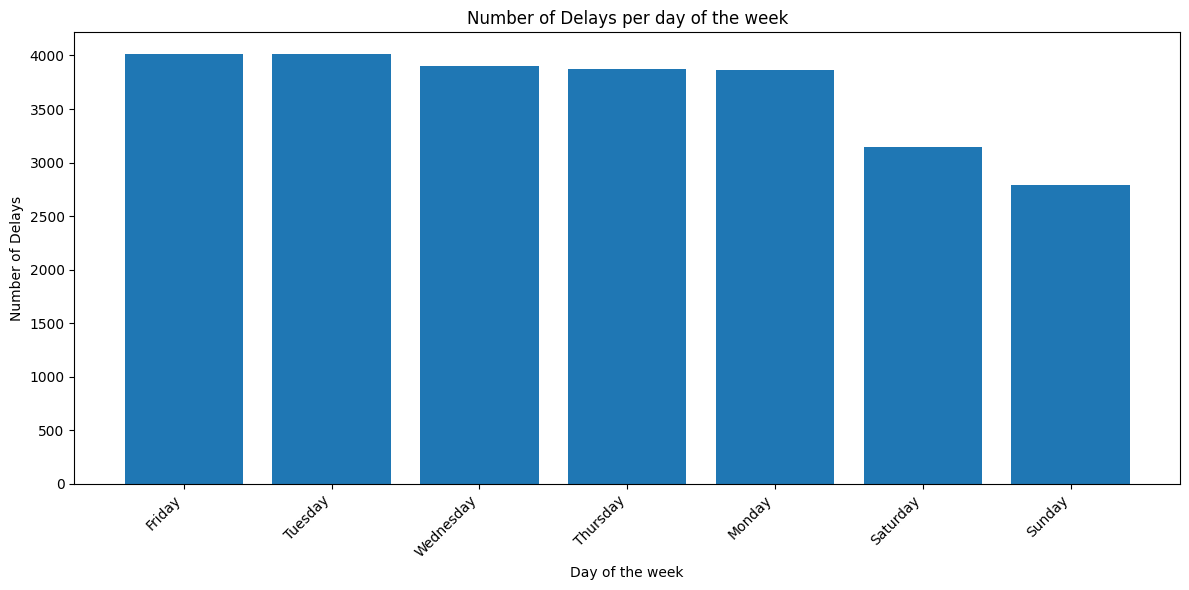

In [ ]:
# Top 10 stations with most delays 
not_null_df = df.dropna(inplace=False)
station_counts = not_null_df['Station'].value_counts().sort_values(ascending=False)
station_counts.head(10)
#Create a bar graph of the stations with most delays
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(station_counts.index, station_counts.values)
plt.xlabel('Station')
plt.ylabel('Number of Delays')
plt.title('Number of Delays per Station')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Days with the most delays
day_counts = not_null_df['Day'].value_counts()
print(not_null_df['Day'].value_counts())
 #Create a bar graph of the day_counts
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(day_counts.index, day_counts.values)
plt.xlabel('Day of the week')
plt.ylabel('Number of Delays')
plt.title('Number of Delays per day of the week')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

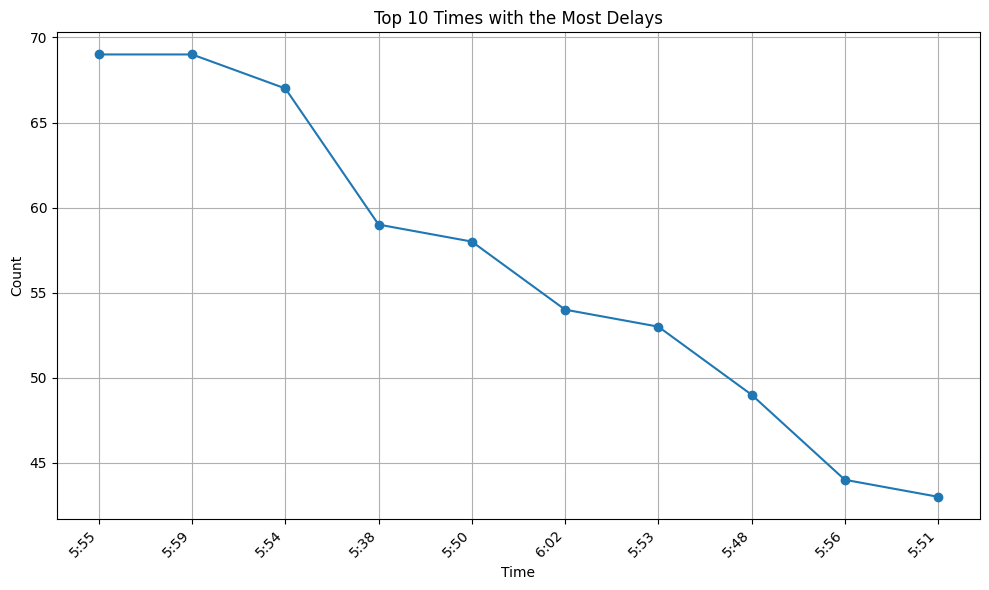

In [44]:
# Time of the day with most delays
time_counts = not_null_df['Time'].value_counts()
time_counts.head(10)
# line graph using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(time_counts.head(10).index, time_counts.head(10).values, marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Top 10 Times with the Most Delays')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [20]:
# 2. Define label encoders for categorical variables
label_encoders = {} # A Mapping between categorical variables and their encoded values
for column in ['Station','Line']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = dict(zip(le.classes_, le.transform(le.classes_)))

print(label_encoders)
print(df.head())

{'Station': {'(APPROACHING) KENNEDY': 0, 'BATHURST STATION': 1, 'BATHURST TO CASTLE FRA': 2, 'BATHUST TO PAPE STATIO': 3, 'BAY LOWER': 4, 'BAY LOWER STATION': 5, 'BAY STATION': 6, 'BAY STATION TO PAPE ST': 7, 'BESSARION STATION': 8, 'BLOOR DANFORTH LINE': 9, 'BLOOR STATION': 10, 'BLOOR TO DAVISVILLE ST': 11, 'BLOOR-DANFORTH LINE': 12, 'BLOOR/DANFORTH LINE': 13, 'BLOOR/YONGE': 14, 'BROADVIEW AND ST GEORG': 15, 'BROADVIEW STATION': 16, 'CASTLE FRANK STATION': 17, 'CHESTER CENTRE TRACK': 18, 'CHESTER STATION': 19, 'CHRISTIE STATION': 20, 'CHRISTIE STATION TO CH': 21, 'CHRISTIE STATION TO PA': 22, 'CHRISTIE TO PAPE STATI': 23, 'CHRSTIE TO PAPE STATIO': 24, 'COLLEGE STATION': 25, 'COLLEGE TO KING': 26, 'COXWELL STATION': 27, 'COXWELL TO KENNEDY': 28, 'DAVISVILLE BUILD UP': 29, 'DAVISVILLE BUILD-UP': 30, 'DAVISVILLE BUILDUP': 31, 'DAVISVILLE STATION': 32, 'DAVISVILLE TO EGLINTON': 33, 'DAVISVILLE TO LAWRENCE': 34, 'DAVISVILLE YARD': 35, 'DONLANDS STATION': 36, 'DOWNSVIEW PARK STATION': 37, '

In [30]:
numeric_cols = ["Hour", "DayOfWeek", "Month", "Minute"]
categorical_cols = ["Station", "Line"]
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [31]:
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols)
])

In [33]:
# 4. Full pipeline: preprocessing + model
pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", XGBRegressor())
])

In [34]:
# 5. Time-based cross-validation + grid search
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    "model__n_estimators": [300],
    "model__learning_rate": [0.01]
}

In [35]:
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

In [36]:
# 6. Fit and evaluate
grid.fit(X, y)
print("Best score:", -grid.best_score_)
print("Best params:", grid.best_params_)
grid_predictions = grid.predict(X)
print("Sample predictions:", grid_predictions[:5])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best score: 15.211312866210937
Best params: {'model__learning_rate': 0.01, 'model__n_estimators': 300}
Sample predictions: [7.7451587 7.2746415 7.9350333 7.9079056 7.2746415]


In [37]:
# Best pipeline found by GridSearchCV
best_pipeline = grid.best_estimator_
y_pred = best_pipeline.predict(X)
print("Sample predictions from best pipeline:", y_pred[:5])
# Split into preprocessing and model
preprocessor = best_pipeline.named_steps["prep"]
model        = best_pipeline.named_steps["model"]
print("Preprocessor:", preprocessor)
print("Model:", model)

Sample predictions from best pipeline: [7.7451587 7.2746415 7.9350333 7.9079056 7.2746415]
Preprocessor: ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Hour', 'DayOfWeek', 'Month', 'Minute']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Station', 'Line'])])
Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
  

Feature names: ['num__Hour' 'num__DayOfWeek' 'num__Month' 'num__Minute'
 'cat__Station_(APPROACHING) KENNEDY' 'cat__Station_BATHURST STATION'
 'cat__Station_BATHURST TO CASTLE FRA'
 'cat__Station_BATHUST TO PAPE STATIO' 'cat__Station_BAY LOWER'
 'cat__Station_BAY LOWER STATION' 'cat__Station_BAY STATION'
 'cat__Station_BAY STATION TO PAPE ST' 'cat__Station_BESSARION STATION'
 'cat__Station_BLOOR DANFORTH LINE' 'cat__Station_BLOOR STATION'
 'cat__Station_BLOOR TO DAVISVILLE ST' 'cat__Station_BLOOR-DANFORTH LINE'
 'cat__Station_BLOOR/DANFORTH LINE' 'cat__Station_BLOOR/YONGE'
 'cat__Station_BROADVIEW AND ST GEORG' 'cat__Station_BROADVIEW STATION'
 'cat__Station_CASTLE FRANK STATION' 'cat__Station_CHESTER CENTRE TRACK'
 'cat__Station_CHESTER STATION' 'cat__Station_CHRISTIE STATION'
 'cat__Station_CHRISTIE STATION TO CH'
 'cat__Station_CHRISTIE STATION TO PA'
 'cat__Station_CHRISTIE TO PAPE STATI'
 'cat__Station_CHRSTIE TO PAPE STATIO' 'cat__Station_COLLEGE STATION'
 'cat__Station_COLLEGE T

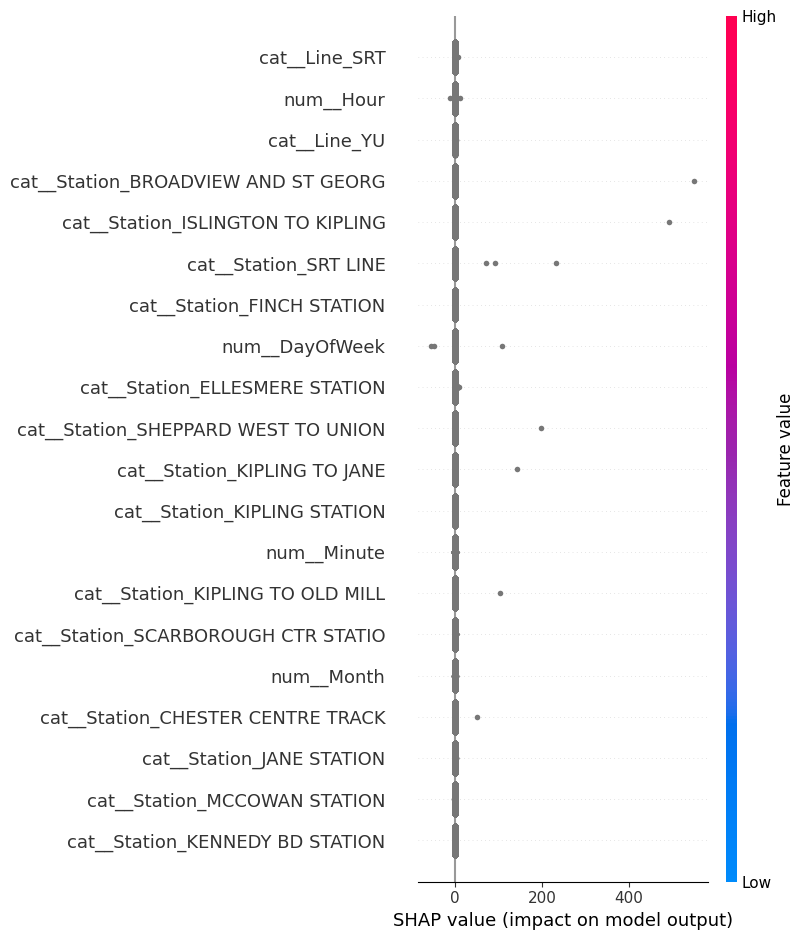

In [38]:
#get feature names
feature_names = preprocessor.get_feature_names_out()
print("Feature names:", feature_names)

# Compute SHAP values for the entire dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer(preprocessor.transform(X))
# Visualize SHAP values
shap.summary_plot(shap_values, feature_names=feature_names)



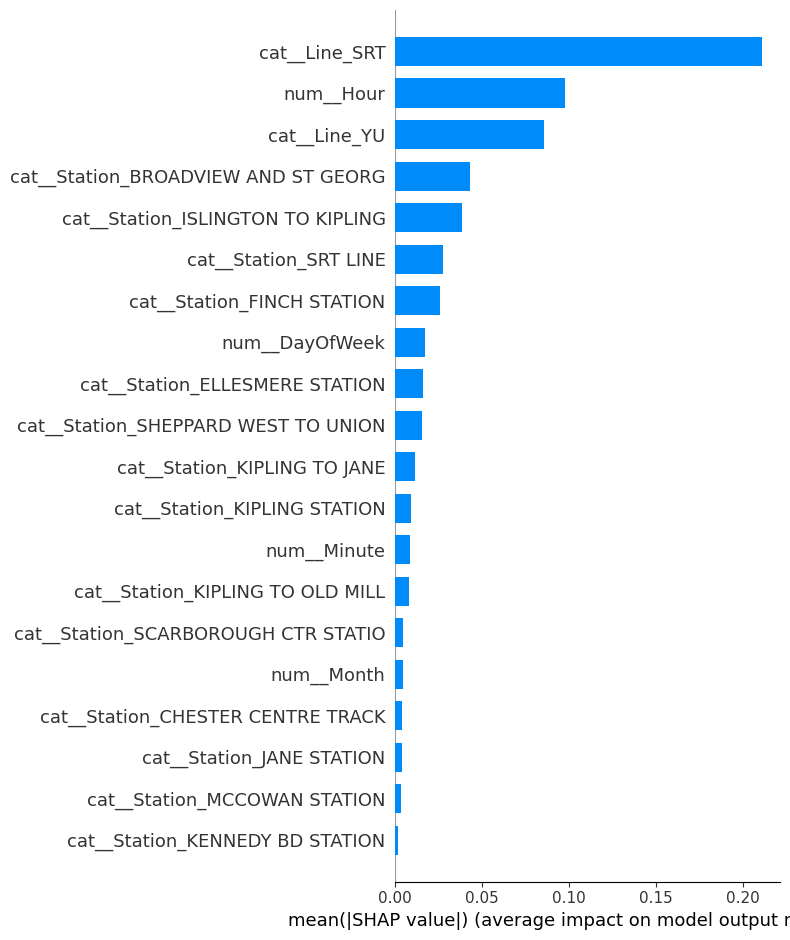

In [39]:
shap.summary_plot(
    shap_values, 
    preprocessor.transform(X), 
    feature_names=feature_names, 
    plot_type="bar"
)


Shap value plots show that the hour of the day and the Lines influence the delay predictions significantly.